In [ ]:
!pip install numpy opencv-python mediapipe matplotlib seaborn tqdm joblib scikit-learn xgboost

In [21]:
import os
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import pickle
import warnings
import logging
from joblib import Parallel, delayed

# ML kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier

In [23]:
warnings.filterwarnings('ignore')
logging.getLogger("mediapipe").setLevel(logging.ERROR)

In [24]:
mp_face_mesh = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
)
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

W0000 00:00:1732377498.511767     108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732377498.535585     107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [25]:
IMAGE_SIZE = (224, 224)
RANDOM_STATE = 42
DATASET_PATH = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"

# MediaPipe ile yüz özelliklerini çıkarır


In [28]:
def extract_facial_features(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = mp_face_mesh.process(image_rgb)
    
    if not results.multi_face_landmarks:
        return None
        
    face_landmarks = results.multi_face_landmarks[0]
    features = []
    
    # 3D Landmark koordinatları
    landmarks_3d = [[lm.x, lm.y, lm.z] for lm in face_landmarks.landmark]
    features.extend(np.array(landmarks_3d).flatten())
    
    # Geometrik özellikler
    # Göz açıklığı
    left_eye_top = np.mean([landmarks_3d[159], landmarks_3d[145]], axis=0)
    left_eye_bottom = np.mean([landmarks_3d[145], landmarks_3d[163]], axis=0)
    right_eye_top = np.mean([landmarks_3d[386], landmarks_3d[374]], axis=0)
    right_eye_bottom = np.mean([landmarks_3d[374], landmarks_3d[386]], axis=0)
    
    left_eye_opening = np.linalg.norm(left_eye_top - left_eye_bottom)
    right_eye_opening = np.linalg.norm(right_eye_top - right_eye_bottom)
    
    # Ağız açıklığı
    mouth_top = np.mean([landmarks_3d[13], landmarks_3d[14]], axis=0)
    mouth_bottom = np.mean([landmarks_3d[17], landmarks_3d[18]], axis=0)
    mouth_opening = np.linalg.norm(mouth_top - mouth_bottom)
    
    features.extend([left_eye_opening, right_eye_opening, mouth_opening])
    
    return np.array(features)

# Landmarkların görselleştirilmesi

In [29]:
def make_square(image):
    """
    Görüntüyü kare formata dönüştürür.
    - Kenar boşluklarını siyah ile doldurur.
    """
    height, width = image.shape[:2]
    size = max(height, width)
    delta_w = size - width
    delta_h = size - height
    top, bottom = delta_h // 2, delta_h - delta_h // 2
    left, right = delta_w // 2, delta_w - delta_w // 2
    color = [0, 0, 0]  # Siyah kenarlık
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_image


# MediaPipe landmark noktalarını görselleştir

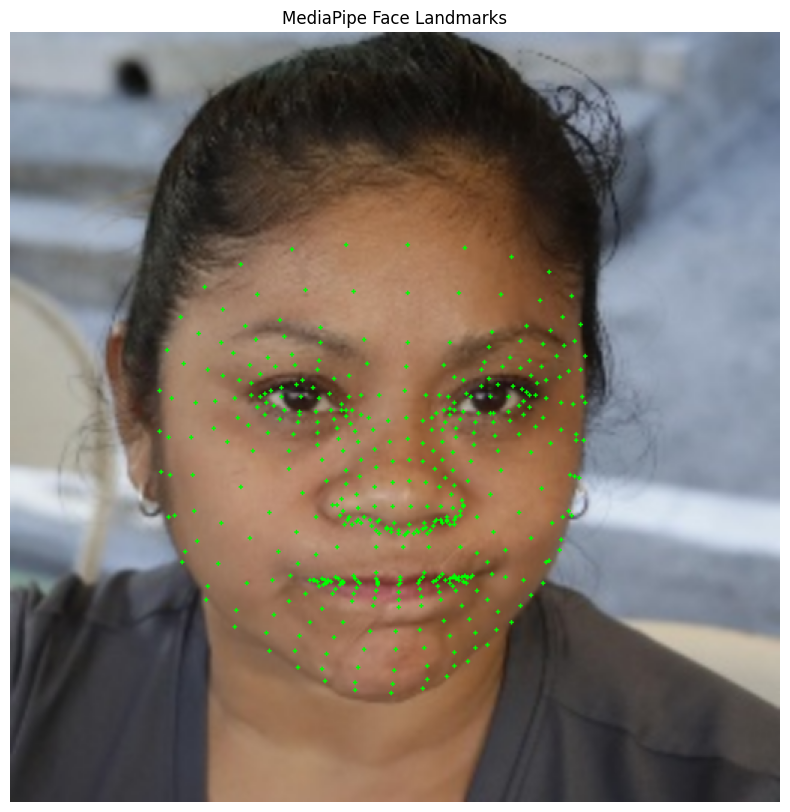

In [30]:
def visualize_landmarks(image, landmarks):
    
    mp_drawing = mp.solutions.drawing_utils
    mp_face_mesh = mp.solutions.face_mesh
    
    annotated_image = image.copy()
    
    # Landmark noktalarını çiz
    for idx, landmark in enumerate(landmarks.landmark):
        x = int(landmark.x * image.shape[1])
        y = int(landmark.y * image.shape[0])
        cv2.circle(annotated_image, (x, y), 1, (0, 255, 0), -1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.title("MediaPipe Face Landmarks")
    plt.axis('off')
    plt.show()

# Test kodu
test_image_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real/00002.jpg"
test_image = cv2.imread(test_image_path)

# Görüntüyü kare hale getir
test_image = make_square(test_image)

# Görüntüyü yeniden boyutlandır
IMAGE_SIZE = (512, 512) 
test_image = cv2.resize(test_image, IMAGE_SIZE)

# Görselleştirme
image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
results = mp_face_mesh.process(image_rgb)

if results.multi_face_landmarks:
    visualize_landmarks(test_image, results.multi_face_landmarks[0])
else:
    print("Yüz tespit edilemedi!")

# Görüntüyü İşleme

In [ ]:
def process_image(image_path):
    
    try:
        image = cv2.imread(image_path)
        if image is None:
            return None
            
        image = cv2.resize(image, IMAGE_SIZE)
        features = extract_facial_features(image)
        
        return features
    except Exception as e:
        print(f"Hata - {image_path}: {str(e)}")
        return None

# Veri seti işleme


In [31]:
def prepare_dataset(base_path, max_samples=None):
    datasets = {}
    
    for split in ['train', 'valid', 'test']:
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            print(f"\n{split.upper()} seti işleniyor...")
            data = []
            labels = []
            
            for category in ["real", "fake"]:
                category_path = os.path.join(split_path, category)
                label = 1 if category == "fake" else 0
                
                image_files = [f for f in os.listdir(category_path) 
                             if f.endswith(('.jpg', '.jpeg', '.png'))]
                
                # max_samples yoksa tüm görüntüler işlenir
                if max_samples:
                    image_files = image_files[:max_samples // 2]
                
                print(f"\n{category.upper()} görüntüler işleniyor...")
                for filename in tqdm(image_files):
                    try:
                        image_path = os.path.join(category_path, filename)
                        features = process_image(image_path)
                        
                        if features is not None:
                            data.append(features)
                            labels.append(label)
                            
                    except Exception as e:
                        print(f"Hata - {filename}: {str(e)}")
            
            if len(data) > 0:
                X = np.array(data)
                y = np.array(labels)
                datasets[split] = (X, y)
                
                print(f"\n{split.upper()} Set İstatistikleri:")
                print(f"İşlenen görüntü sayısı: {len(data)}")
                print(f"Pozitif (fake) örnekler: {sum(y == 1)}")
                print(f"Negatif (real) örnekler: {sum(y == 0)}")
                print(f"Özellik boyutu: {X.shape[1]}")
                
                # Ara kayıt
                save_path = f"/kaggle/working/mediapipe_features_{split}.npz"
                np.savez_compressed(save_path, features=X, labels=y)
            
            gc.collect()
    
    return datasets

# Küçük veri seti ile test
print("Test veri seti işleniyor...")
datasets = prepare_dataset(DATASET_PATH, max_samples=1000)  # Her kategoriden 50 örnek

Test veri seti işleniyor...

TRAIN seti işleniyor...

REAL görüntüler işleniyor...


100%|██████████| 500/500 [00:06<00:00, 82.87it/s]



FAKE görüntüler işleniyor...


100%|██████████| 500/500 [00:06<00:00, 79.33it/s]



TRAIN Set İstatistikleri:
İşlenen görüntü sayısı: 1000
Pozitif (fake) örnekler: 500
Negatif (real) örnekler: 500
Özellik boyutu: 1437

VALID seti işleniyor...

REAL görüntüler işleniyor...


100%|██████████| 500/500 [00:06<00:00, 82.80it/s]



FAKE görüntüler işleniyor...


100%|██████████| 500/500 [00:06<00:00, 83.19it/s]



VALID Set İstatistikleri:
İşlenen görüntü sayısı: 999
Pozitif (fake) örnekler: 500
Negatif (real) örnekler: 499
Özellik boyutu: 1437

TEST seti işleniyor...

REAL görüntüler işleniyor...


100%|██████████| 500/500 [00:05<00:00, 83.49it/s]



FAKE görüntüler işleniyor...


100%|██████████| 500/500 [00:06<00:00, 80.57it/s]



TEST Set İstatistikleri:
İşlenen görüntü sayısı: 1000
Pozitif (fake) örnekler: 500
Negatif (real) örnekler: 500
Özellik boyutu: 1437


# Model eğitimi


In [32]:
def train_models(datasets):
    X_train, y_train = datasets['train']
    X_val, y_val = datasets.get('valid', datasets['test'])
    X_test, y_test = datasets['test']
    
    # Standardizasyon
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print("Veri seti boyutları:")
    print(f"Eğitim seti: {X_train.shape}")
    print(f"Doğrulama seti: {X_val.shape}")
    print(f"Test seti: {X_test.shape}\n")

    try:
        # XGBoost - GPU 0
        print("\nXGBoost GPU-0 eğitimi başlıyor...")
        xgb_0 = XGBClassifier(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.01,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method='hist',
            device='cuda:0',
            random_state=RANDOM_STATE
        )
        xgb_0.fit(X_train_scaled, y_train)
        
        # XGBoost - GPU 1
        print("\nXGBoost GPU-1 eğitimi başlıyor...")
        xgb_1 = XGBClassifier(
            n_estimators=500,
            max_depth=7,
            learning_rate=0.01,
            subsample=0.9,
            colsample_bytree=0.9,
            tree_method='hist',
            device='cuda:1',
            random_state=RANDOM_STATE+1
        )
        xgb_1.fit(X_train_scaled, y_train)
        
        # Random Forest
        print("\nRandom Forest eğitimi başlıyor...")
        rf_model = RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            n_jobs=1,
            random_state=RANDOM_STATE
        )
        rf_model.fit(X_train_scaled, y_train)
        
        # Voting Classifier
        voting_clf = VotingClassifier(
            estimators=[
                ('xgb_0', xgb_0),
                ('xgb_1', xgb_1),
                ('rf', rf_model)
            ],
            voting='soft',
            weights=[1.2, 1.2, 1]
        )
        
        print("\nFinal model eğitimi başlıyor...")
        voting_clf.fit(X_train_scaled, y_train)
        
        # Sonuçları hesapla
        val_pred = voting_clf.predict(X_val_scaled)
        val_pred_proba = voting_clf.predict_proba(X_val_scaled)
        test_pred = voting_clf.predict(X_test_scaled)
        test_pred_proba = voting_clf.predict_proba(X_test_scaled)
        
        results = {
            'validation': {
                'accuracy': accuracy_score(y_val, val_pred),
                'roc_auc': roc_auc_score(y_val, val_pred_proba[:, 1]),
                'confusion_matrix': confusion_matrix(y_val, val_pred),
                'classification_report': classification_report(y_val, val_pred)
            },
            'test': {
                'accuracy': accuracy_score(y_test, test_pred),
                'roc_auc': roc_auc_score(y_test, test_pred_proba[:, 1]),
                'confusion_matrix': confusion_matrix(y_test, test_pred),
                'classification_report': classification_report(y_test, test_pred)
            },
            'model': voting_clf,
            'scaler': scaler
        }
        
        return results
        
    except Exception as e:
        print(f"Model eğitimi sırasında hata: {str(e)}")
        raise e


# Model sonuçlarını görselleştirir


In [33]:
def plot_results(results, X_test, y_test):
    
    plt.figure(figsize=(15, 5))
    
    # Karışıklık matrisi
    plt.subplot(1, 2, 1)
    sns.heatmap(results['test']['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Karışıklık Matrisi')
    plt.xlabel('Tahmin')
    plt.ylabel('Gerçek')
    
    # ROC eğrisi
    plt.subplot(1, 2, 2)
    y_pred_proba = results['model'].predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Yanlış Pozitif Oranı')
    plt.ylabel('Doğru Pozitif Oranı')
    plt.title(f"ROC Eğrisi (AUC = {results['test']['roc_auc']:.4f})")
    
    plt.tight_layout()
    plt.show()


Veri seti işleniyor...

TRAIN seti işleniyor...

REAL görüntüler işleniyor...


100%|██████████| 50000/50000 [16:49<00:00, 49.53it/s]



FAKE görüntüler işleniyor...


100%|██████████| 50000/50000 [18:26<00:00, 45.18it/s]



TRAIN Set İstatistikleri:
İşlenen görüntü sayısı: 99992
Pozitif (fake) örnekler: 50000
Negatif (real) örnekler: 49992
Özellik boyutu: 1437

VALID seti işleniyor...

REAL görüntüler işleniyor...


100%|██████████| 10000/10000 [03:45<00:00, 44.35it/s]



FAKE görüntüler işleniyor...


100%|██████████| 10000/10000 [03:32<00:00, 47.02it/s]



VALID Set İstatistikleri:
İşlenen görüntü sayısı: 19997
Pozitif (fake) örnekler: 10000
Negatif (real) örnekler: 9997
Özellik boyutu: 1437

TEST seti işleniyor...

REAL görüntüler işleniyor...


100%|██████████| 10000/10000 [03:39<00:00, 45.52it/s]



FAKE görüntüler işleniyor...


100%|██████████| 10000/10000 [03:28<00:00, 47.87it/s]



TEST Set İstatistikleri:
İşlenen görüntü sayısı: 19998
Pozitif (fake) örnekler: 10000
Negatif (real) örnekler: 9998
Özellik boyutu: 1437

Model eğitimi başlıyor...
Veri seti boyutları:
Eğitim seti: (99992, 1437)
Doğrulama seti: (19997, 1437)
Test seti: (19998, 1437)


XGBoost GPU-0 eğitimi başlıyor...

XGBoost GPU-1 eğitimi başlıyor...

Random Forest eğitimi başlıyor...

Final model eğitimi başlıyor...

=== Model Sonuçları ===
Validation Sonuçları:
Accuracy: 0.8076
ROC AUC: 0.8929

Test Sonuçları:
Accuracy: 0.8094
ROC AUC: 0.8931

Test Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      9998
           1       0.80      0.83      0.81     10000

    accuracy                           0.81     19998
   macro avg       0.81      0.81      0.81     19998
weighted avg       0.81      0.81      0.81     19998



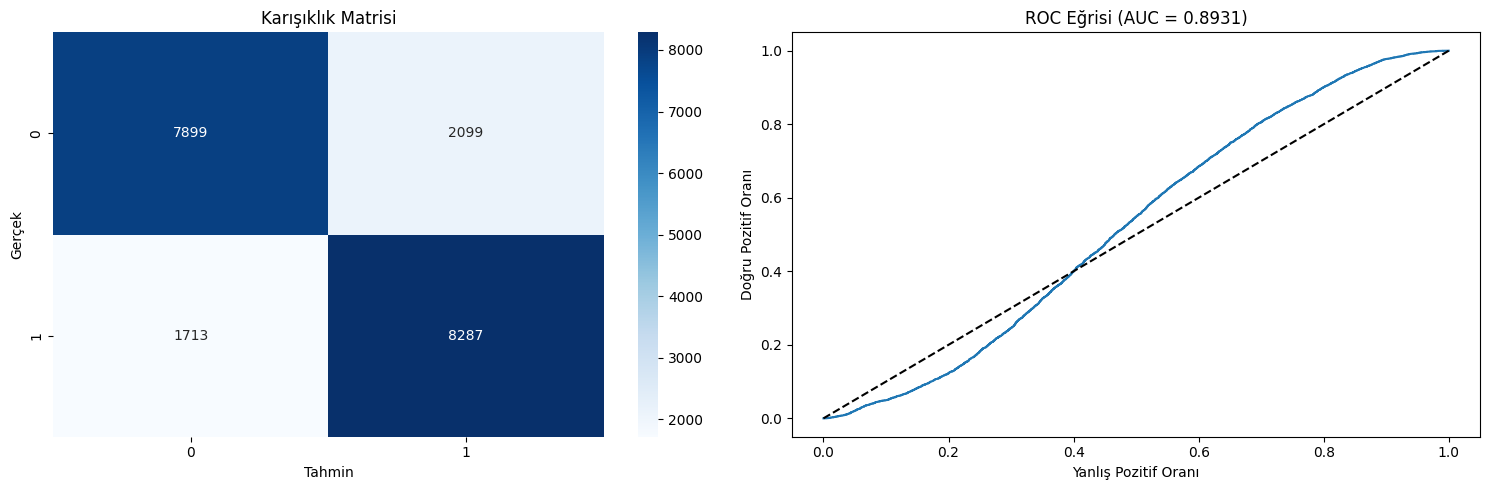

In [34]:
# Ana çalıştırma kodu
print("Veri seti işleniyor...")
datasets = prepare_dataset(DATASET_PATH)

if datasets:
    print("\nModel eğitimi başlıyor...")
    results = train_models(datasets)
    
    # Sonuçları göster
    print("\n=== Model Sonuçları ===")
    print("Validation Sonuçları:")
    print(f"Accuracy: {results['validation']['accuracy']:.4f}")
    print(f"ROC AUC: {results['validation']['roc_auc']:.4f}")
    print("\nTest Sonuçları:")
    print(f"Accuracy: {results['test']['accuracy']:.4f}")
    print(f"ROC AUC: {results['test']['roc_auc']:.4f}")
    print("\nTest Sınıflandırma Raporu:")
    print(results['test']['classification_report'])
    
    # Sonuçları görselleştir
    plot_results(results, datasets['test'][0], datasets['test'][1])
    
    # Modeli kaydet
    with open('/kaggle/working/mediapipe_model.pkl', 'wb') as f:
        pickle.dump({
            'model': results['model'],
            'scaler': results['scaler']
        }, f)